<a href="https://colab.research.google.com/github/cadenzonnefeld/DTSA5511/blob/main/Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Histopathalogic Cancer Detection

The aim of this project is to detect metastatic cancer in images taken from pathology scans. The data used for this project is a modified verison of the PCam dataset which is both clinically relevent and straight forward problem to appraoch as it is a binary classfiication problem. The dataset consists of nearly 300,000 images each of which is (96, 96, 3) in dimensions.

We will use Convolutional Neural Networks (CNN) to process the patholgy scans and classify whether or not an image contains metastic cancer. The appeal of a cancer detection model like this is readily apparant as it could supplement primary care physicians or even give early results by leveraging a model that is effective in detecting metastatic cancer.

### Package Import and Data Loading

Importing the Python packages that will be needed to operate this project.

In [1]:
import os
import keras
import tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

Establishing a connection to my Google Drive and using linux commands to hit Kaggle's API to collect the dataset for this competition/project.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cadenzonefeld","key":"d0a0fadb8d1e4ba8c191b6e6e913f4b5"}'}

In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd

-rw-r--r-- 1 root root 69 Oct 10 14:15 kaggle.json
/content


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                          title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                      Most Streamed Spotify Songs 2023                   47KB  2023-08-26 11:04:57          26966        810  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset           Customer Shopping Trends Dataset                  146KB  2023-10-05 06:45:37           2301         54  1.0              
nelgiriyewithana/credit-card-fraud-detection-dataset-2023    Credit Card Fraud Detection Dataset 2023          143MB  2023-09-18 10:00:19           4153        137  1.0              
nelgiriyewithana/billionaires-statistics-dataset             Billionaires Statistics 

In [7]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [03:59<00:00, 29.9MB/s]
100% 6.31G/6.31G [03:59<00:00, 28.3MB/s]


In [8]:
!unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

Loading the train and test datasets which consist of many pathology scan images.

In [15]:
train_dir = "/content/train"
test_dir = "/content/test"

In [10]:
train_images = []
for image in os.listdir(train_dir):
    image_path = train_dir+"/"+image

    temp_image = Image.open(image_path)
    temp_image_array = np.array(temp_image)
    temp_image.close()

    train_images.append(temp_image_array)

test_images = []
for image in os.listdir(test_dir):
    image_path = test_dir+"/"+image

    temp_image = Image.open(image_path)
    temp_image_array = np.array(temp_image)
    temp_image.close()

    test_images.append(temp_image)

Consider the number of images in the train and test datasets.

In [ ]:
print("Images in train data:",len(train_images))
print("Images in test data:", len(test_images))

Images in train data: 220025
Images in test data: 57458


Inspecting a handful of examples of what the images in the dataset look like.

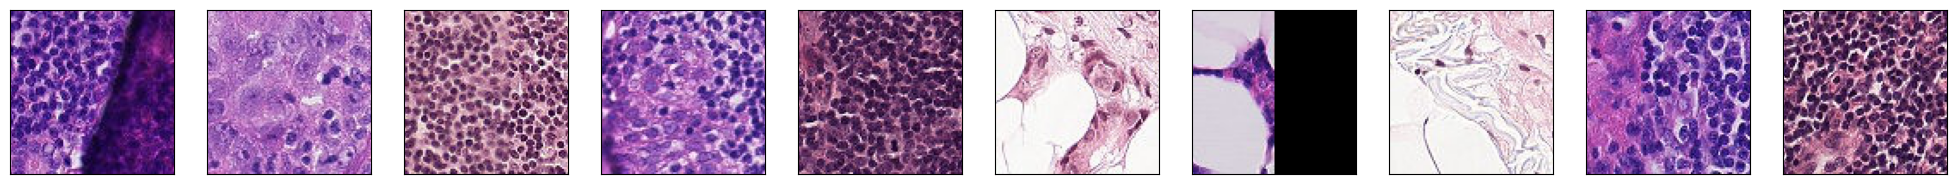

In [ ]:
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open("./train/"+os.listdir(train_dir)[i])
    plt.imshow(im)

Loading in the labels for the train dataset and inspecting the format of an example submission for the Kaggle challenge.

In [9]:
train_labels = pd.read_csv("./train_labels.csv")
sample = pd.read_csv("./sample_submission.csv")

Adding a column to the train_labels df that has the path to each given image. Furthermore, we convert the label field to a string which will be needed when we use an image data generator later.

In [10]:
train_labels['path'] = "./train/"+train_labels['id']+".tif"
train_labels['label'] = train_labels['label'].astype(str)

The labels for the ten example images above.

In [ ]:
for i in range(10):
    print(train_labels[train_labels['id']+".tif" == os.listdir(train_dir)[i]]['label'])

208177    1
Name: label, dtype: object
149200    1
Name: label, dtype: object
106844    0
Name: label, dtype: object
74170    1
Name: label, dtype: object
172330    0
Name: label, dtype: object
64284    1
Name: label, dtype: object
153386    0
Name: label, dtype: object
184502    0
Name: label, dtype: object
136639    0
Name: label, dtype: object
59567    0
Name: label, dtype: object


### EDA

Exploring the distribution of labels in the training dataset.

In [ ]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

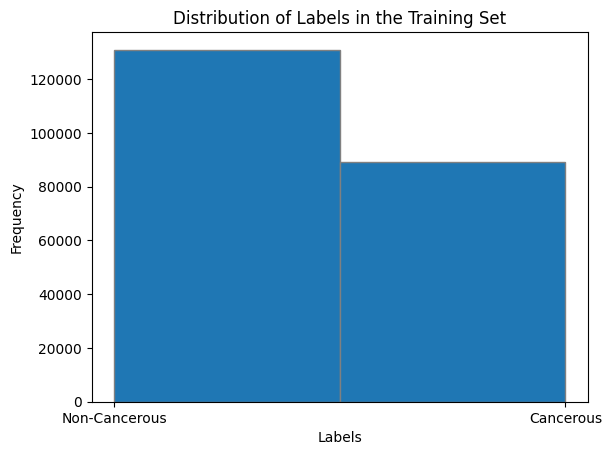

In [ ]:
plt.hist(train_labels['label'], bins=2, edgecolor='grey')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Set')
plt.show()

Though the classes are imblanced with about 60% of images being non-cancerous and 40% of images being cancerous the imbalance is not significant enough to need to perform class re-balancing. However, if this proves to be challenge to later modeling efforts, we will return to balance the classes.

We previously viewed some example images from the training set, we will now look to see if there are noticeable visible differences that are detectable by a layperson from a visual inspection.

In [ ]:
train_labels_viz = train_labels.copy()
train_labels_viz['label'] = train_labels_viz['label'].astype(int)

Cancerous Images (Top Row) v. Non-Cancerous Images (Bottom Row)


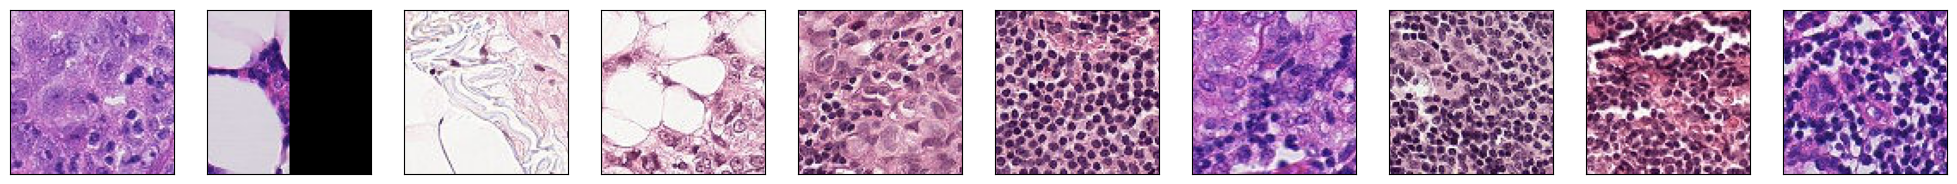

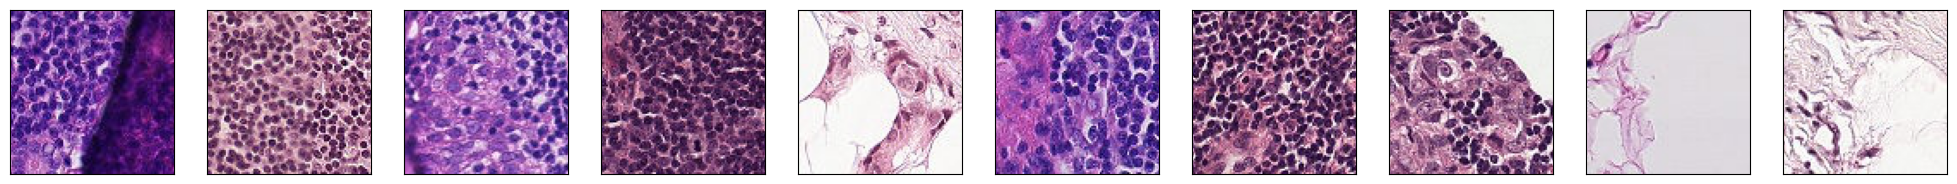

In [ ]:
print("Cancerous Images (Top Row) v. Non-Cancerous Images (Bottom Row)")
fig = plt.figure(figsize=(25, 4))
i = 0
count = 0
non_names = []
while count < 10:
    if train_labels_viz.iloc[i, 1] == 1:
        ax = fig.add_subplot(1, 10, count + 1, xticks=[], yticks=[])
        im = Image.open("./train/"+os.listdir(train_dir)[i])
        plt.imshow(im)
        count += 1
    i += 1


fig = plt.figure(figsize=(25, 4))
i = 0
count = 0
names = []
while count < 10:
    if train_labels_viz.iloc[i, 1] == 0:
        ax = fig.add_subplot(1, 10, count + 1, xticks=[], yticks=[])
        im = Image.open("./train/"+os.listdir(train_dir)[i])
        plt.imshow(im)
        count += 1
    i += 1

Upon a cursory visual inspection there are no marked differences between the cancerous and non-cancerous iamges. Both take on similar colors from the staining process and have features like large hollow white cells and small purple cells. Futhermore, there is a wide variety of images in each data set. The difficulty of classifiying these images for the average person serves as a motivation for creating an effective image classifier.

Since the data consists of images and it is difficult (nigh impossible) for a layperson to detect the differences in the structure of the images we will turn to modeling to decipher the key differences between the cancerous and non-cancerous images.

### Modeling

To begin, we will create a Convolutional Neural Network due to their large body of success in image processing and classification.

The first step will be splitting the training images and labels into a train and validation set so that we can properly fit a model.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.3, stratify=train_labels.iloc[:, 1])

Now we have a reduced training set of images that accounts for 70% of the original training images and a validation set that accounts for 30% of the original training images. We stratified the split to ensure that both the training and validation data experience the same level of class balance; we validate the class balance below.

In [ ]:
print('Training Class Balance')
print(y_train['label'].value_counts(normalize=True))
print('\nValidation Class Balance')
print(y_val['label'].value_counts(normalize=True))

Training Class Balance
0    0.594967
1    0.405033
Name: label, dtype: float64

Validation Class Balance
0    0.594973
1    0.405027
Name: label, dtype: float64


Ran into memory issues when trying to use a more common ML approach of using train_test_split and storing the data in full as large arrays. As a result, pivoted to using the ImageDataGenerator package from Keras which allows images to be processed in batches and significantly speeds things up.

The data generator implements batch loading which loads images into memory as needed for each batch and replaces them when the next batch comes. This reduces the strain on memory during training. The ImageDataGenerator() object rescales the RGB pixels in each image to fall between 0 and 1 and also exexcutes an 70-30 validation split.

In [11]:
datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagenerator.flow_from_dataframe(
    dataframe=train_labels,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

validation_generator = datagenerator.flow_from_dataframe(
    dataframe=train_labels,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

Found 154018 non-validated image filenames belonging to 2 classes.
Found 66007 non-validated image filenames belonging to 2 classes.


Creating the genarator for the test dataset.

In [16]:
ids = [file[:-4] for file in os.listdir(test_dir)]
files = ["./test/"+file for file in os.listdir(test_dir)]

test_dataframe = pd.DataFrame()
test_dataframe['id'] = ids
test_dataframe['file'] = files

In [17]:
test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col='file',
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


#### First Model
First pass at classifying the data this time using a sequential, dense neural network as studied in earlier modeules. The network consists of a layer that flattens the input into an array and then dense, fully connected flayers of size 128, 64, 32, and 16 with a 'relu' activation and then finally an output layers with a 'sigmoid' activation.

In [ ]:
dense_model = models.Sequential()
dense_model.add(layers.Flatten(input_shape=(96, 96, 3)))
dense_model.add(layers.Dense(128, activation='relu'))
dense_model.add(layers.Dense(64, activation='relu'))
dense_model.add(layers.Dense(32, activation='relu'))
dense_model.add(layers.Dense(16, activation='relu'))
dense_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 128)               3539072   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3549953 (13.54 MB)
Trainable params: 35499

In [ ]:
dense_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history = dense_model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 545s 112ms/step - loss: 0.6362 - accuracy: 0.6287 - auc: 0.6605 - val_loss: 0.5991 - val_accuracy: 0.6781 - val_auc: 0.7232
Epoch 2/5
4814/4814 [==============================] - 531s 110ms/step - loss: 0.5967 - accuracy: 0.6800 - auc: 0.7290 - val_loss: 0.5898 - val_accuracy: 0.6927 - val_auc: 0.7715
Epoch 3/5
4814/4814 [==============================] - 587s 122ms/step - loss: 0.5737 - accuracy: 0.7034 - auc: 0.7584 - val_loss: 0.5981 - val_accuracy: 0.6883 - val_auc: 0.7741
Epoch 4/5
4814/4814 [==============================] - 540s 112ms/step - loss: 0.5669 - accuracy: 0.7097 - auc: 0.7655 - val_loss: 0.5599 - val_accuracy: 0.7149 - val_auc: 0.7796
Epoch 5/5
4814/4814 [==============================] - 540s 112ms/step - loss: 0.5603 - accuracy: 0.7144 - auc: 0.7715 - val_loss: 0.5596 - val_accuracy: 0.7141 - val_auc: 0.7813


Visualizing the performance of the model over its training period.

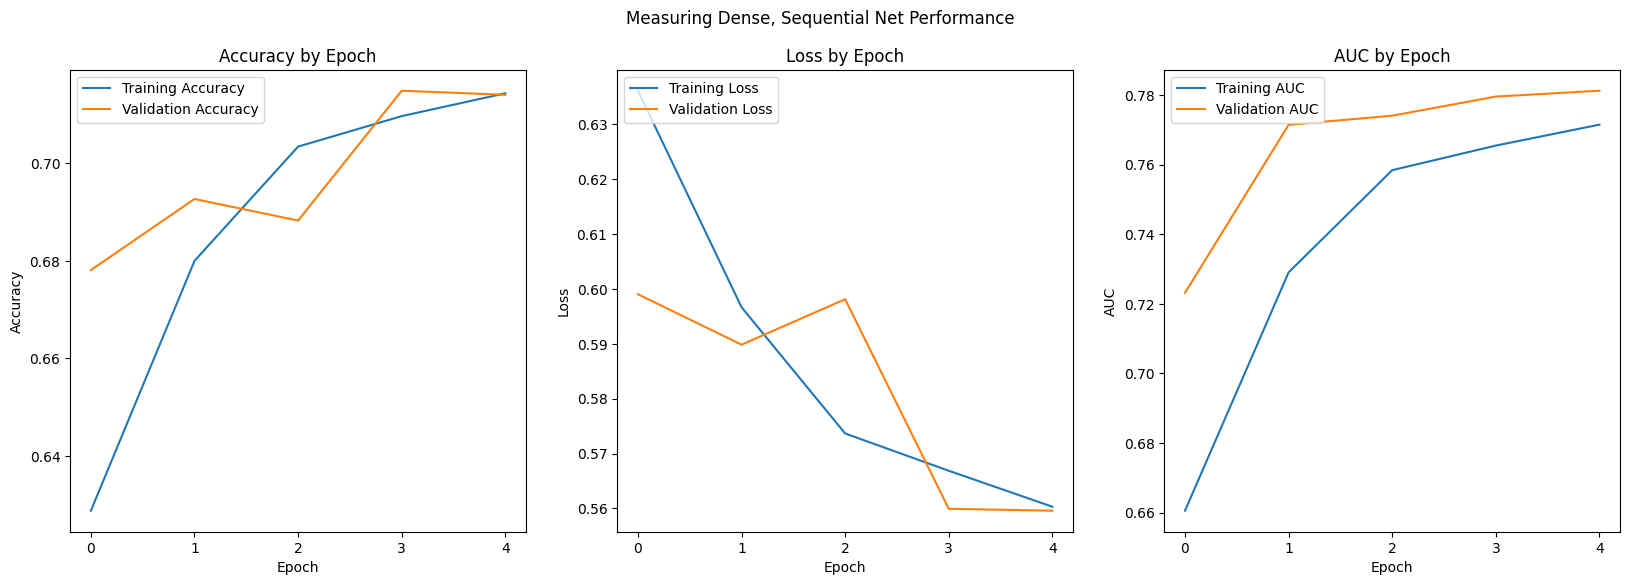

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history.history['loss'], label = 'Training Loss')
ax2.plot(history.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history.history['auc'], label = 'Training AUC')
ax3.plot(history.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring Dense, Sequential Net Performance')
plt.show()

Though it appeared after the third epoch's completion that the model may have begun to overfit since the validation accuracy decreased and loss increased the fourth and fifth epoch indicated that there was still room for the neural network to improve in its predictive capacity.

Unfortunately, due to memory and time constraints I was unable to let this model run for more epochs to see how it performed; the training metrics appear to be reaching a point of diminishing returns so it would have been interesting to see hwo the validation metrics reacted.

While this model does a solid job, this architecture is only able to process raw pixels and is unable to interpret nearness of pixels to each other and larger structures so when we test a CNN next I am confident that it will outperform this model.

#### CNN Model (Max Pooling)
Next pass at classifying the data this time using a convolutional neural network which is more suitable for the task at hand due to the wide-ranging success of CNNs in image processing and classification. This model is a CNN that consists of the following layers
* Convolutional Layer with 32 3x3 filters (Reduced input from 96x96x3 to 94x94x32)
* Max Pooling Layer with 2x2 filter (Reduced input from prior layer from 94x94x32 to 47x47x32)
* Convolutional Layer with 32 3x3 filters (Reduced input from prior layer from 47x47x32 to 45x45x32)
* Max Pooling Layer with 2x2 filter (Reduced input from prior layer from 45x45x32 to 22x22x32)
* Convolutional Layer with 16 3x3 filters (Reduced input from prior layer from 22x22x32 to 20x20x16)
* Flattening Layer (Reshapes input from prior layer from 20x20x16 to 6400x1)
* Dense Layer (Reshapes input from prior layer from 6400x1 to 128x1) $\textit{(Featurizing the output from convolutions)}$
* Dense Layer (Reshapes input from prior layer to an output with a sigmoid activation to predict likelihood of being cancerous)

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

Note that this CNN architecture requires 834,225 parameters which is about a quarter of the parameters needed for the Dense, Sequential architecture above that used 3,549,953.

In [ ]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        4624      
                                                                 
 flatten_4 (Flatten)         (None, 6400)             

In [ ]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history = cnn_model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 1181s 245ms/step - loss: 0.4365 - accuracy: 0.7994 - auc: 0.8727 - val_loss: 0.3602 - val_accuracy: 0.8482 - val_auc: 0.9184
Epoch 2/5
4814/4814 [==============================] - 1191s 247ms/step - loss: 0.3394 - accuracy: 0.8546 - auc: 0.9253 - val_loss: 0.3071 - val_accuracy: 0.8725 - val_auc: 0.9443
Epoch 3/5
4814/4814 [==============================] - 953s 198ms/step - loss: 0.2977 - accuracy: 0.8759 - auc: 0.9426 - val_loss: 0.2799 - val_accuracy: 0.8866 - val_auc: 0.9514
Epoch 4/5
4814/4814 [==============================] - 1010s 210ms/step - loss: 0.2717 - accuracy: 0.8874 - auc: 0.9524 - val_loss: 0.2641 - val_accuracy: 0.8934 - val_auc: 0.9550
Epoch 5/5
4814/4814 [==============================] - 891s 185ms/step - loss: 0.2504 - accuracy: 0.8975 - auc: 0.9595 - val_loss: 0.2755 - val_accuracy: 0.8874 - val_auc: 0.9519


Visualizing the performance of the CNN model according to several metrics

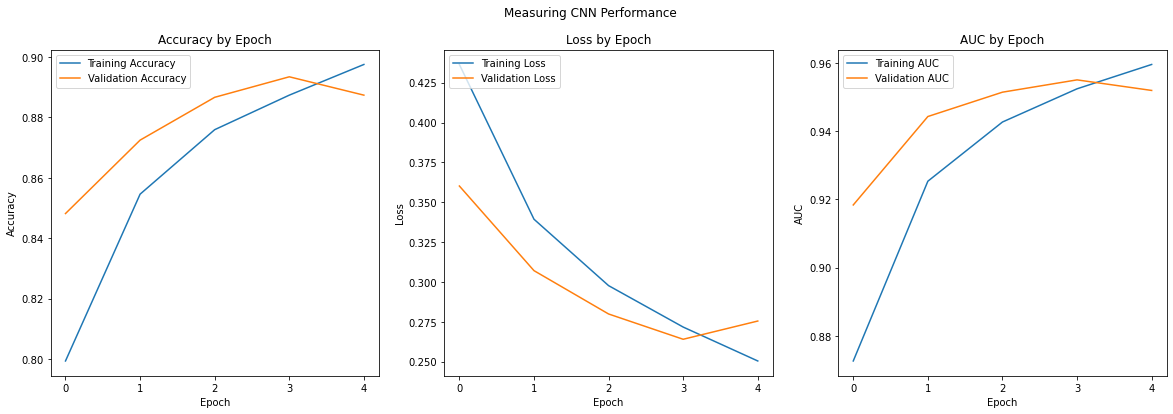

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history.history['loss'], label = 'Training Loss')
ax2.plot(history.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history.history['auc'], label = 'Training AUC')
ax3.plot(history.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN Performance')
plt.show()

The CNN model provides strong performance and is a marked improvemnet from the prior Sequential, Dense network. The prior model was peaked at an accuracy of around 72% while this model peaks at around 89% while using a quarter of the parameters. The validation AUC of this model plateous at around 0.95 which indicates a strong ability to separate between cancerous and non-cancerous images.

I would have been interested to have more computing power and time to see how this model progressed with more epochs. Though the model may improve with more epochs, with each of the validation metrics (accuracy, loss, AUC) peaking after the fourth epoch and declining after the fifth epoch it appears that the point of overfitting may have been reached.

Now that we have created a model with good performance we will try tweaking the model by tuning different hyperparameters to improve our results.

#### CNN Model (Average pooling)

This model tweaks the previous iteration of the CNN model by replacing the max pooling layers with average pooling layers.

In [ ]:
cnn_model_avg_pooling = models.Sequential()
cnn_model_avg_pooling.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model_avg_pooling.add(layers.AveragePooling2D((2, 2)))
cnn_model_avg_pooling.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_avg_pooling.add(layers.AveragePooling2D((2, 2)))
cnn_model_avg_pooling.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_avg_pooling.add(layers.Flatten())
cnn_model_avg_pooling.add(layers.Dense(128, activation='relu'))
cnn_model_avg_pooling.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_avg_pooling.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 average_pooling2d (Average  (None, 47, 47, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 average_pooling2d_1 (Avera  (None, 22, 22, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 16)        4624      
                                                                 
 flatten_5 (Flatten)         (None, 6400)             

In [ ]:
cnn_model_avg_pooling.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_avg_pooling = cnn_model_avg_pooling.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 866s 180ms/step - loss: 0.4307 - accuracy: 0.8029 - auc: 0.8762 - val_loss: 0.4346 - val_accuracy: 0.8229 - val_auc: 0.9129
Epoch 2/5
4814/4814 [==============================] - 790s 164ms/step - loss: 0.3469 - accuracy: 0.8503 - auc: 0.9222 - val_loss: 0.3330 - val_accuracy: 0.8583 - val_auc: 0.9339
Epoch 3/5
4814/4814 [==============================] - 799s 166ms/step - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9392 - val_loss: 0.2957 - val_accuracy: 0.8746 - val_auc: 0.9438
Epoch 4/5
4814/4814 [==============================] - 797s 166ms/step - loss: 0.2746 - accuracy: 0.8856 - auc: 0.9518 - val_loss: 0.3181 - val_accuracy: 0.8683 - val_auc: 0.9402
Epoch 5/5
4814/4814 [==============================] - 805s 167ms/step - loss: 0.2460 - accuracy: 0.8997 - auc: 0.9611 - val_loss: 0.2939 - val_accuracy: 0.8805 - val_auc: 0.9447


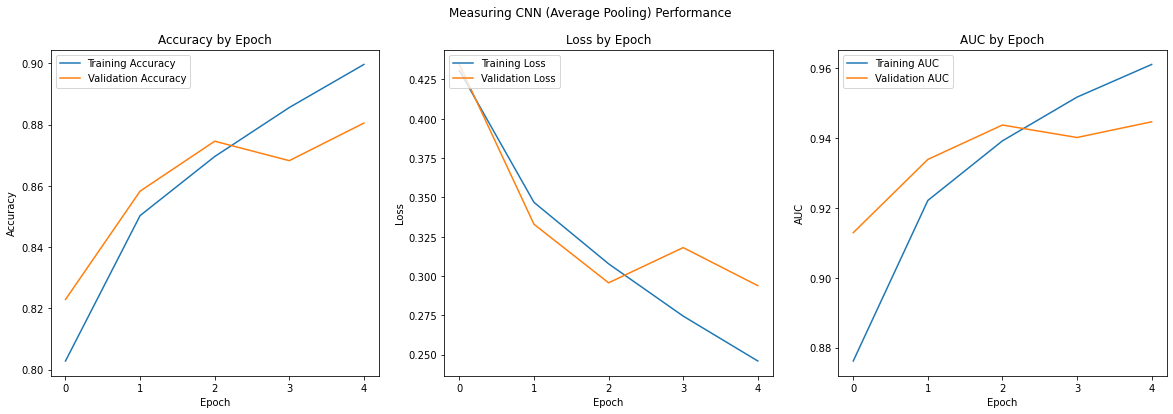

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_avg_pooling.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_avg_pooling.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_avg_pooling.history['loss'], label = 'Training Loss')
ax2.plot(history_avg_pooling.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_avg_pooling.history['auc'], label = 'Training AUC')
ax3.plot(history_avg_pooling.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN (Average Pooling) Performance')
plt.show()

Implementing the CNN with average pooling performs well like the max pooling variatn before. Across the training period the average pooling CNN tends to be a slighly worse version of the max pooling CNN. Knowing this, we will turn our efforts to other hyperparameter tuning opportunities that use max pooling.

#### CNN (Dropout Layers)
Adjusting our CNN to include dropout layers after each of the max pooling layers. The dropout layers nullifies some of the weights and helps prevent the model overfitting, particularly to the early batches of data that it sees.

In [ ]:
cnn_model_dropout = models.Sequential()
cnn_model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_model_dropout.add(layers.Dropout(0.4)) #Note the addition of this dropout
cnn_model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_model_dropout.add(layers.Dropout(0.4)) #Note the addition of this dropout
cnn_model_dropout.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_dropout.add(layers.Flatten())
cnn_model_dropout.add(layers.Dense(128, activation='relu'))
cnn_model_dropout.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_dropout.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 32)      

In [ ]:
cnn_model_dropout.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_dropout = cnn_model_dropout.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 1054s 219ms/step - loss: 0.4462 - accuracy: 0.7948 - auc: 0.8669 - val_loss: 0.4700 - val_accuracy: 0.7758 - val_auc: 0.9114
Epoch 2/5
4814/4814 [==============================] - 874s 182ms/step - loss: 0.3613 - accuracy: 0.8434 - auc: 0.9151 - val_loss: 0.3980 - val_accuracy: 0.8259 - val_auc: 0.9292
Epoch 3/5
4814/4814 [==============================] - 880s 183ms/step - loss: 0.3292 - accuracy: 0.8599 - auc: 0.9299 - val_loss: 0.4038 - val_accuracy: 0.8285 - val_auc: 0.9184
Epoch 4/5
4814/4814 [==============================] - 896s 186ms/step - loss: 0.3135 - accuracy: 0.8675 - auc: 0.9368 - val_loss: 0.4053 - val_accuracy: 0.8270 - val_auc: 0.9260
Epoch 5/5
4814/4814 [==============================] - 927s 193ms/step - loss: 0.3025 - accuracy: 0.8732 - auc: 0.9411 - val_loss: 0.4044 - val_accuracy: 0.8439 - val_auc: 0.9364


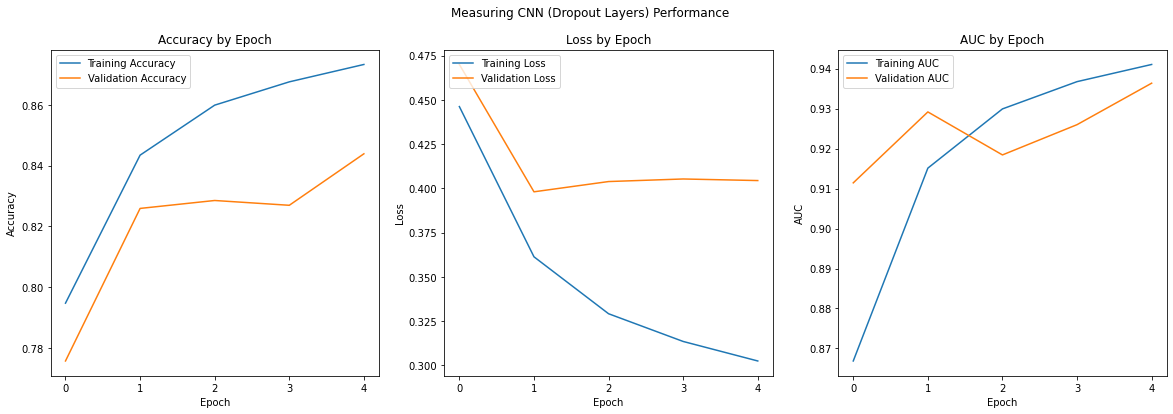

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_dropout.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_dropout.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_dropout.history['loss'], label = 'Training Loss')
ax2.plot(history_dropout.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_dropout.history['auc'], label = 'Training AUC')
ax3.plot(history_dropout.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN (Dropout Layers) Performance')
plt.show()

The CNN with dropout layers helps guard against overfitting but in the process its also lessened the models ability to pick up on some of the true signal in the data as it performs well but measurably worse than the two prior CNNs that were trained on this data.

#### CNN (Regularization)

In [ ]:
cnn_model_normalization = models.Sequential()
cnn_model_normalization.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model_normalization.add(layers.MaxPooling2D((2, 2)))
cnn_model_normalization.add(layers.BatchNormalization()) #Note the addition of this batch normalization
cnn_model_normalization.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_normalization.add(layers.MaxPooling2D((2, 2)))
cnn_model_normalization.add(layers.BatchNormalization()) #Note the addition of this batch normalization
cnn_model_normalization.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_normalization.add(layers.Flatten())
cnn_model_normalization.add(layers.Dense(128, activation='relu'))
cnn_model_normalization.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_normalization.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 47, 47, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                     

In [ ]:
cnn_model_normalization.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_normalization = cnn_model_normalization.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 968s 201ms/step - loss: 0.3641 - accuracy: 0.8427 - auc: 0.9141 - val_loss: 0.3475 - val_accuracy: 0.8435 - val_auc: 0.9431
Epoch 2/5
4814/4814 [==============================] - 897s 186ms/step - loss: 0.2881 - accuracy: 0.8814 - auc: 0.9464 - val_loss: 0.2606 - val_accuracy: 0.8941 - val_auc: 0.9568
Epoch 3/5
4814/4814 [==============================] - 870s 181ms/step - loss: 0.2544 - accuracy: 0.8960 - auc: 0.9582 - val_loss: 0.2759 - val_accuracy: 0.8887 - val_auc: 0.9530
Epoch 4/5
4814/4814 [==============================] - 915s 190ms/step - loss: 0.2313 - accuracy: 0.9065 - auc: 0.9653 - val_loss: 0.3046 - val_accuracy: 0.8768 - val_auc: 0.9427
Epoch 5/5
4814/4814 [==============================] - 977s 203ms/step - loss: 0.2054 - accuracy: 0.9176 - auc: 0.9727 - val_loss: 0.3484 - val_accuracy: 0.8586 - val_auc: 0.9219


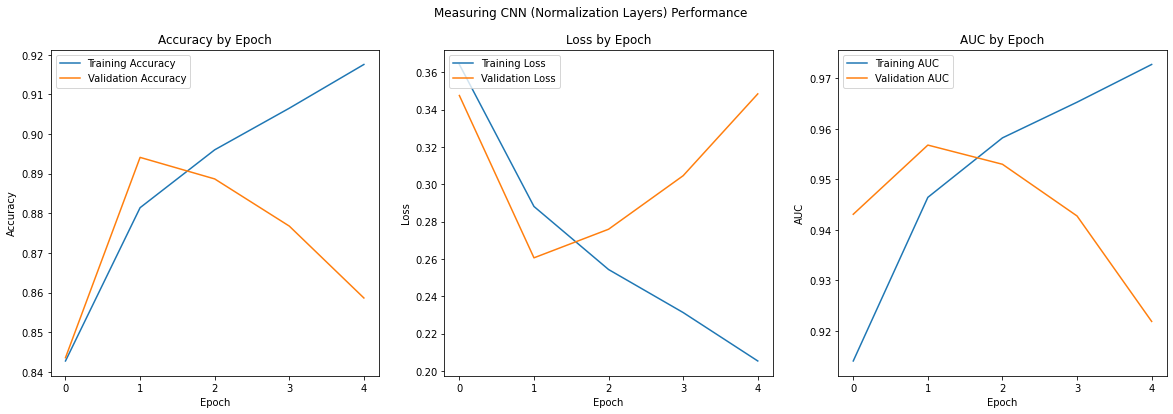

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_normalization.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_normalization.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_normalization.history['loss'], label = 'Training Loss')
ax2.plot(history_normalization.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_normalization.history['auc'], label = 'Training AUC')
ax3.plot(history_normalization.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN (Normalization Layers) Performance')
plt.show()

Adding the normalization layers to the CNN provided strong early performance with the accuracy, loss, and AUC nearly matching the best of any model that has been examined so far; however, after the second epoch there are clear signs of overfitting as each of the validation metrics degrades over the next three epochs while the training metrics increase.

#### CNN (Nadam Optimizer)
Much like the last several iterations of CNN modeling we will adapt a portion of the model. This time we are swapping out the 'adam' optimizer for the 'nadam' optimizer to see if making use of Nesterov momentum improves our results.

In [ ]:
cnn_model_nadam = models.Sequential()
cnn_model_nadam.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model_nadam.add(layers.MaxPooling2D((2, 2)))
cnn_model_nadam.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_nadam.add(layers.MaxPooling2D((2, 2)))
cnn_model_nadam.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_nadam.add(layers.Flatten())
cnn_model_nadam.add(layers.Dense(128, activation='relu'))
cnn_model_nadam.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_nadam.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 20, 20, 16)        4624      
                                                                 
 flatten_12 (Flatten)        (None, 6400)            

In [ ]:
cnn_model_nadam.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_nadam = cnn_model_nadam.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 862s 179ms/step - loss: 0.4204 - accuracy: 0.8052 - auc: 0.8821 - val_loss: 0.4011 - val_accuracy: 0.8265 - val_auc: 0.9267
Epoch 2/5
4814/4814 [==============================] - 824s 171ms/step - loss: 0.3171 - accuracy: 0.8665 - auc: 0.9345 - val_loss: 0.2880 - val_accuracy: 0.8803 - val_auc: 0.9462
Epoch 3/5
4814/4814 [==============================] - 857s 178ms/step - loss: 0.2840 - accuracy: 0.8823 - auc: 0.9475 - val_loss: 0.2736 - val_accuracy: 0.8891 - val_auc: 0.9517
Epoch 4/5
4814/4814 [==============================] - 963s 200ms/step - loss: 0.2612 - accuracy: 0.8931 - auc: 0.9557 - val_loss: 0.3006 - val_accuracy: 0.8768 - val_auc: 0.9451
Epoch 5/5
4814/4814 [==============================] - 1132s 235ms/step - loss: 0.2371 - accuracy: 0.9033 - auc: 0.9634 - val_loss: 0.2710 - val_accuracy: 0.8923 - val_auc: 0.9534


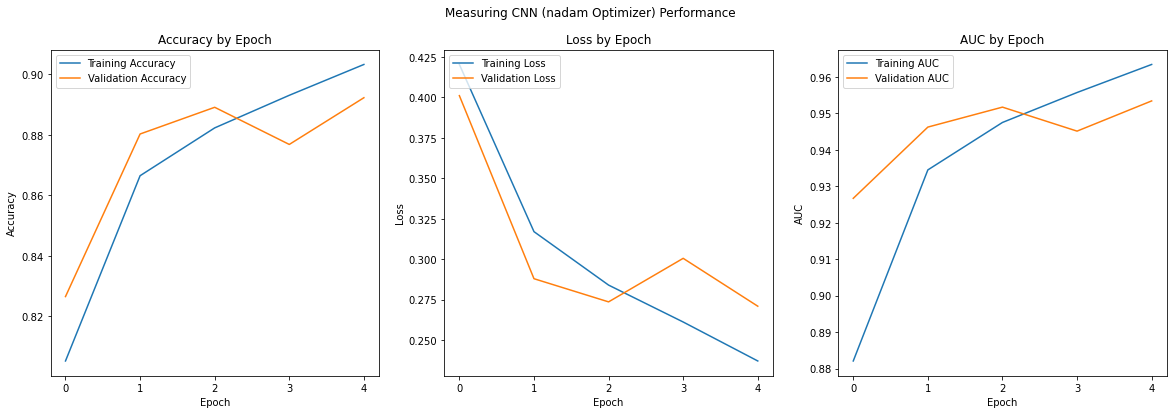

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_nadam.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_nadam.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_nadam.history['loss'], label = 'Training Loss')
ax2.plot(history_nadam.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_nadam.history['auc'], label = 'Training AUC')
ax3.plot(history_nadam.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN (nadam Optimizer) Performance')
plt.show()

The CNN using the 'nadam' optimizer performed very similarly to the 'adam' optimizer which is not particulary surprising since the former is based on the latter. Unfortunately, I was not able to run more epochs based on memory and time constraints, as I would have been interested to see the results as the validation metrics may still be improving to give a better model fit.

#### Deeper Model
Having tuned our original CNN model in a variety of ways including changing the pooling strategy, adding normalization layers, adding dropout layers, and changing optimizers we have noticed that hyperparamters are helpful for tuning but provide similar results on a whole.

Now we are going to shift gears and look to make a deeper model to see if that will provide better predictive power. Though we could add more convolutional and/or pooling layers we will start by featurizing the flattened layer into 256 features instead of 128 features and also add an intermediate Dense layers of 32 nodes before the output layer.

In [ ]:
cnn_model_deeper = models.Sequential()
cnn_model_deeper.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model_deeper.add(layers.MaxPooling2D((2, 2)))
cnn_model_deeper.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_deeper.add(layers.MaxPooling2D((2, 2)))
cnn_model_deeper.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_deeper.add(layers.Flatten())
cnn_model_deeper.add(layers.Dense(256, activation='relu'))
cnn_model_deeper.add(layers.Dense(128, activation='relu'))
cnn_model_deeper.add(layers.Dense(32, activation='relu'))
cnn_model_deeper.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_deeper.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 20, 20, 16)        4624      
                                                                 
 flatten_13 (Flatten)        (None, 6400)            

In [ ]:
cnn_model_deeper.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_deeper = cnn_model_deeper.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 1026s 212ms/step - loss: 0.4119 - accuracy: 0.8155 - auc: 0.8882 - val_loss: 0.3466 - val_accuracy: 0.8530 - val_auc: 0.9251
Epoch 2/5
4814/4814 [==============================] - 931s 193ms/step - loss: 0.3155 - accuracy: 0.8671 - auc: 0.9357 - val_loss: 0.2793 - val_accuracy: 0.8823 - val_auc: 0.9497
Epoch 3/5
4814/4814 [==============================] - 946s 197ms/step - loss: 0.2743 - accuracy: 0.8873 - auc: 0.9515 - val_loss: 0.2948 - val_accuracy: 0.8778 - val_auc: 0.9443
Epoch 4/5
4814/4814 [==============================] - 1049s 218ms/step - loss: 0.2419 - accuracy: 0.9028 - auc: 0.9622 - val_loss: 0.2700 - val_accuracy: 0.8899 - val_auc: 0.9554
Epoch 5/5
4814/4814 [==============================] - 1005s 209ms/step - loss: 0.2057 - accuracy: 0.9185 - auc: 0.9724 - val_loss: 0.2703 - val_accuracy: 0.8915 - val_auc: 0.9536


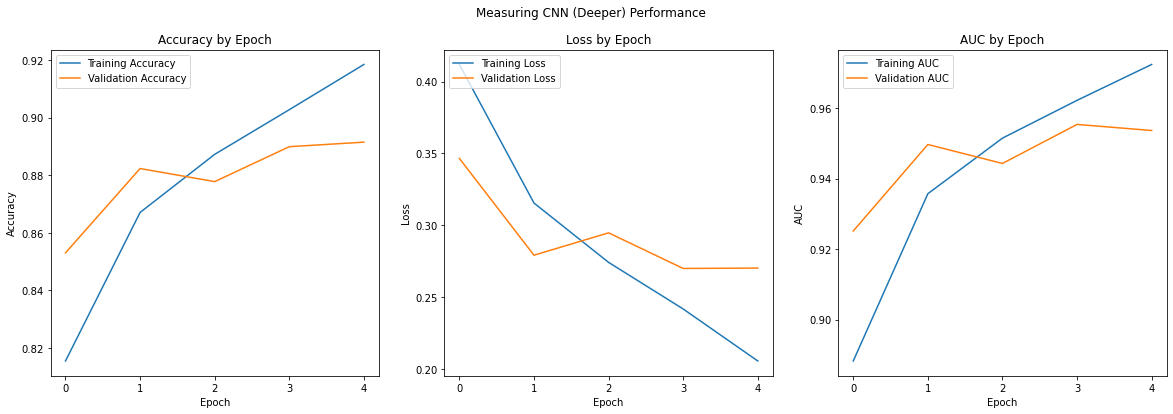

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_deeper.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_deeper.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_deeper.history['loss'], label = 'Training Loss')
ax2.plot(history_deeper.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_deeper.history['auc'], label = 'Training AUC')
ax3.plot(history_deeper.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN (Deeper) Performance')
plt.show()

#### Crossover Model
Adapting previous iterations of the model by including some normalization layers, and more dense layers to make the model deeper.

In [ ]:
cnn_model_new = models.Sequential()
cnn_model_new.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model_new.add(layers.BatchNormalization())
cnn_model_new.add(layers.MaxPooling2D((2, 2)))
cnn_model_new.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_new.add(layers.BatchNormalization())
cnn_model_new.add(layers.MaxPooling2D((2, 2)))
cnn_model_new.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_new.add(layers.Flatten())
cnn_model_new.add(layers.Dense(256, activation='relu'))
cnn_model_new.add(layers.Dense(32, activation='relu'))
cnn_model_new.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_new.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_2 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_3 (Bat  (None, 45, 45, 32)        128       
 chNormalization)                                                
                                                     

In [ ]:
cnn_model_new.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_new = cnn_model_new.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 1547s 321ms/step - loss: 0.3614 - accuracy: 0.8463 - auc: 0.9156 - val_loss: 0.3465 - val_accuracy: 0.8571 - val_auc: 0.9235
Epoch 2/5
4814/4814 [==============================] - 1694s 352ms/step - loss: 0.2886 - accuracy: 0.8812 - auc: 0.9463 - val_loss: 0.2729 - val_accuracy: 0.8907 - val_auc: 0.9510
Epoch 3/5
4814/4814 [==============================] - 1444s 300ms/step - loss: 0.2459 - accuracy: 0.9015 - auc: 0.9607 - val_loss: 0.3440 - val_accuracy: 0.8643 - val_auc: 0.9496
Epoch 4/5
4814/4814 [==============================] - 1594s 331ms/step - loss: 0.2079 - accuracy: 0.9169 - auc: 0.9715 - val_loss: 0.4567 - val_accuracy: 0.8286 - val_auc: 0.9186
Epoch 5/5
4814/4814 [==============================] - 1526s 317ms/step - loss: 0.1616 - accuracy: 0.9383 - auc: 0.9824 - val_loss: 0.4382 - val_accuracy: 0.8563 - val_auc: 0.9217


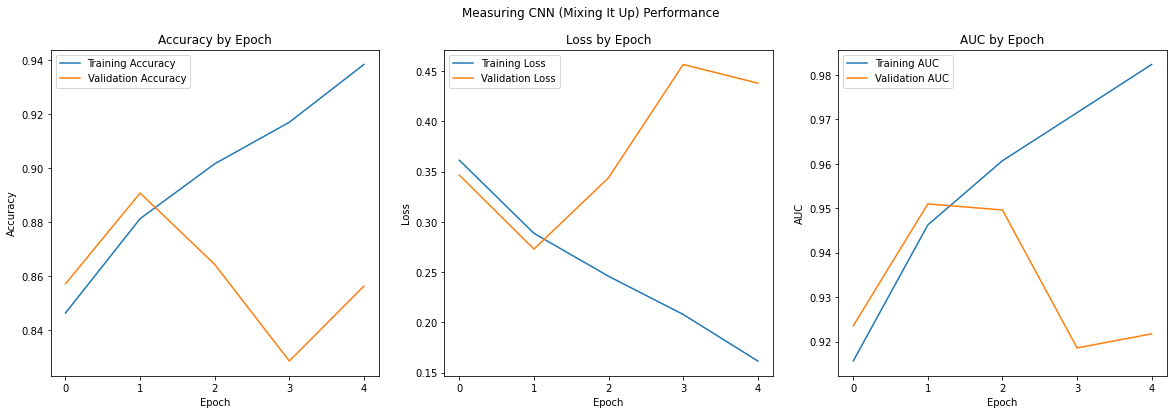

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_new.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_new.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_new.history['loss'], label = 'Training Loss')
ax2.plot(history_new.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_new.history['auc'], label = 'Training AUC')
ax3.plot(history_new.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN (Mixing It Up) Performance')
plt.show()

As we've seen in prior renditions of the CNN architecture, this model appears to be overfitting based on the deteriotaion of the validation metrics; however, it would be beneficial to see how the scores trend over a larger number of epochs. Nevertheless, this model performs well after the second epoch nearly matching the best performance from the first CNN.

#### New Model
One final attempt by mixing things up more than previous iterations of hyperparameter tuning.

In [16]:
c = models.Sequential()
c.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
c.add(layers.BatchNormalization())
c.add(layers.MaxPooling2D((2, 2)))
c.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
c.add(layers.BatchNormalization())
c.add(layers.MaxPooling2D((2, 2)))
c.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
c.add(layers.BatchNormalization())
c.add(layers.MaxPooling2D((2, 2)))
c.add(layers.Conv2D(32, (3, 3), activation='relu'))
c.add(layers.BatchNormalization())
c.add(layers.MaxPooling2D((2, 2)))
c.add(layers.Conv2D(16, (3, 3), activation='relu'))
c.add(layers.Flatten())
c.add(layers.Dense(256, activation='relu'))
c.add(layers.Dense(1, activation='sigmoid'))

In [17]:
c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 96)        2688      
                                                                 
 batch_normalization (Batch  (None, 94, 94, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        55360     
                                                                 
 batch_normalization_1 (Bat  (None, 45, 45, 64)        256       
 chNormalization)                                                
                                                        

In [19]:
c.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_c = c.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
4814/4814 [==============================] - 693s 142ms/step - loss: 0.2623 - accuracy: 0.8935 - auc: 0.9548 - val_loss: 0.3658 - val_accuracy: 0.8342 - val_auc: 0.9306
Epoch 2/5
4814/4814 [==============================] - 647s 134ms/step - loss: 0.2311 - accuracy: 0.9095 - auc: 0.9646 - val_loss: 0.2911 - val_accuracy: 0.8831 - val_auc: 0.9494
Epoch 3/5
4814/4814 [==============================] - 655s 136ms/step - loss: 0.2113 - accuracy: 0.9169 - auc: 0.9704 - val_loss: 0.2055 - val_accuracy: 0.9199 - val_auc: 0.9719
Epoch 4/5
4814/4814 [==============================] - 665s 138ms/step - loss: 0.1952 - accuracy: 0.9241 - auc: 0.9746 - val_loss: 0.2738 - val_accuracy: 0.8934 - val_auc: 0.9512
Epoch 5/5
4814/4814 [==============================] - 658s 137ms/step - loss: 0.1822 - accuracy: 0.9299 - auc: 0.9777 - val_loss: 0.2668 - val_accuracy: 0.8933 - val_auc: 0.9688


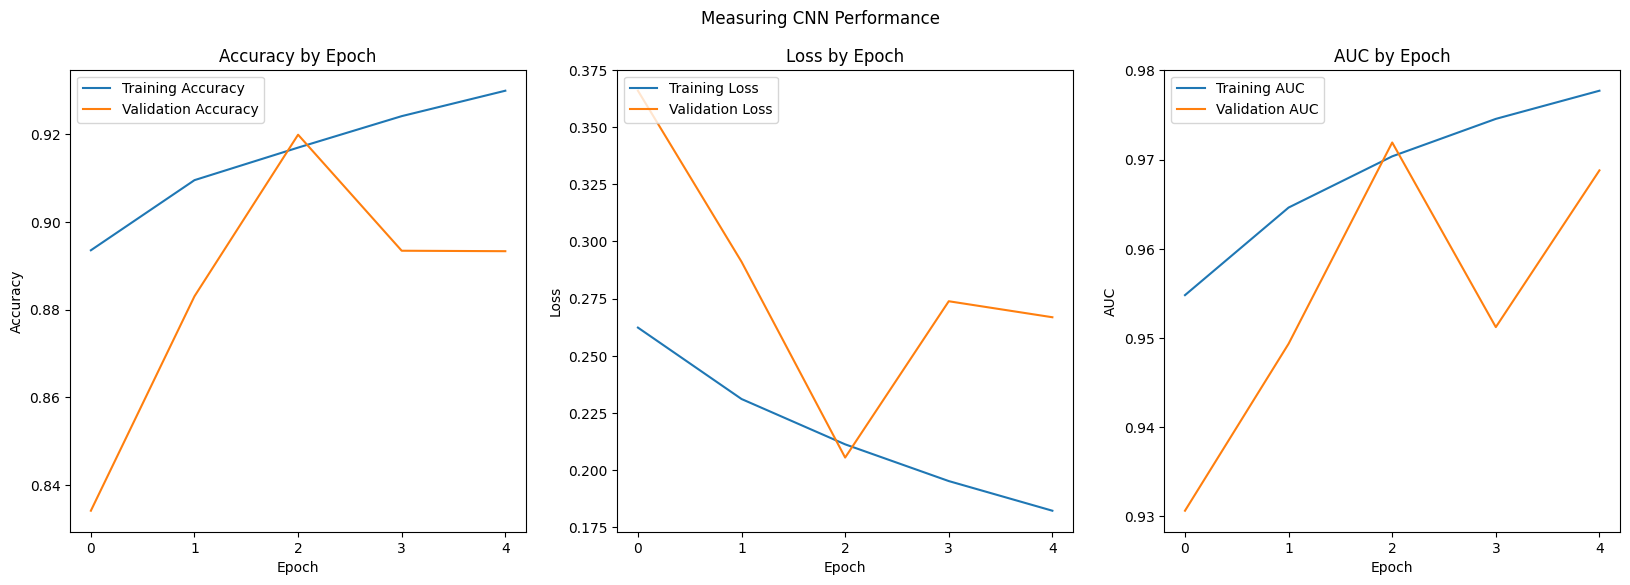

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy
ax1.plot(history_c.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history_c.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(0, 5, 1))
ax1.set_title('Accuracy by Epoch')
ax1.legend(loc='upper left')

# Loss
ax2.plot(history_c.history['loss'], label = 'Training Loss')
ax2.plot(history_c.history['val_loss'], label = 'Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(0, 5, 1))
ax2.set_title('Loss by Epoch')
ax2.legend(loc='upper left')

# AUC
ax3.plot(history_c.history['auc'], label = 'Training AUC')
ax3.plot(history_c.history['val_auc'], label = 'Validation AUC')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')
ax3.set_xticks(np.arange(0, 5, 1))
ax3.set_title('AUC by Epoch')
ax3.legend(loc='upper left')

fig.suptitle('Measuring CNN Performance')
plt.show()

#### Reproducing Prior Model with 3 epochs just for submission scoring purposes.
Creating a version of the prior model with just 3 epochs to match where the model's performance peaked according to the above charts.

In [20]:
c_less_epochs = models.Sequential()
c_less_epochs.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
c_less_epochs.add(layers.BatchNormalization())
c_less_epochs.add(layers.MaxPooling2D((2, 2)))
c_less_epochs.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
c_less_epochs.add(layers.BatchNormalization())
c_less_epochs.add(layers.MaxPooling2D((2, 2)))
c_less_epochs.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
c_less_epochs.add(layers.BatchNormalization())
c_less_epochs.add(layers.MaxPooling2D((2, 2)))
c_less_epochs.add(layers.Conv2D(32, (3, 3), activation='relu'))
c_less_epochs.add(layers.BatchNormalization())
c_less_epochs.add(layers.MaxPooling2D((2, 2)))
c_less_epochs.add(layers.Conv2D(16, (3, 3), activation='relu'))
c_less_epochs.add(layers.Flatten())
c_less_epochs.add(layers.Dense(256, activation='relu'))
c_less_epochs.add(layers.Dense(1, activation='sigmoid'))

In [27]:
c_less_epochs.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

history_c_less_epochs = c_less_epochs.fit(train_generator, epochs=3, validation_data=validation_generator)

Epoch 1/3
4814/4814 [==============================] - 479s 98ms/step - loss: 0.1690 - accuracy: 0.9359 - auc: 0.9807 - val_loss: 0.4684 - val_accuracy: 0.8578 - val_auc: 0.9328
Epoch 2/3
4814/4814 [==============================] - 430s 89ms/step - loss: 0.1607 - accuracy: 0.9391 - auc: 0.9825 - val_loss: 0.3278 - val_accuracy: 0.8751 - val_auc: 0.9546
Epoch 3/3
4814/4814 [==============================] - 426s 88ms/step - loss: 0.1542 - accuracy: 0.9419 - auc: 0.9838 - val_loss: 0.2014 - val_accuracy: 0.9250 - val_auc: 0.9743


#### Preparing Output Data for Kaggle Submission

In [ ]:
sample

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [28]:
test_probabilities = c.predict(test_generator)

1796/1796 [==============================] - 96s 53ms/step


In [29]:
test_labels = np.round(test_probabilities).astype(int)

output = pd.DataFrame()
output['id'] = ids
output['label'] = test_labels

In [30]:
from google.colab import files
output.to_csv('test_labels.csv')
files.download('test_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
output

,id,label
0,3d47d3ed44fc54531a3250d30b2d98f6de045d44,0
1,36487e097b73a5da2b83c9ccb682c2aea1ce47ee,0
2,0287c7a33ec7be3a15863798be9cfabcaab760ba,1
3,c67d9c1b44b894abe1cf1d9a2fe1648276582da6,1
4,2f9c9791b3e93cf41bb89d6fea816af353865bd4,0
...,...,...
57453,b4d55d58ec8fa216445a3e47f88b13ce0353ecee,1
57454,8967e1af36db51ecb95a2480014e9032634f450e,1
57455,2aa9ddd99f351ce86bab072ad93bce7b93d1b9d9,0
57456,8f0d3fc8ec8a824dfd67510f83de9b64f1ea5751,0


## Conclusion

#### Initial Approach
We have explored a variety of techniques to build the best classifier for the histopathologic cancer images. After a brief exploration of the data we turned to neural networks to help us classify images that a layperson is unable to differentiate between cancerous and non-cancerous.

Beginning with a dense network we found that it proved useful as a classifier as it was able to identify images with about 72% accuracy and an AUC of 0.78; however, the shortcomings of the dense network are the vast number of parameters that need to be updated as well as maintaining no concept of nearness of pixels or larger structures.

#### Baseline CNN Architecture
Due to these shortcomings we turned to Convolutional Neural Networks (CNNs) to create a classifier. We began with a fairly simple CNN that contained the following layers:
* Convolutional Layer with 32 3x3 filters (Reduced input from 96x96x3 to 94x94x32)
* Max Pooling Layer with 2x2 filter (Reduced input from prior layer from 94x94x32 to 47x47x32)
* Convolutional Layer with 32 3x3 filters (Reduced input from prior layer from 47x47x32 to 45x45x32)
* Max Pooling Layer with 2x2 filter (Reduced input from prior layer from 45x45x32 to 22x22x32)
* Convolutional Layer with 16 3x3 filters (Reduced input from prior layer from 22x22x32 to 20x20x16)
* Flattening Layer (Reshapes input from prior layer from 20x20x16 to 6400x1)
* Dense Layer (Reshapes input from prior layer from 6400x1 to 128x1) $\textit{(Featurizing the output from convolutions)}$
* Dense Layer (Reshapes input from prior layer to an output with a sigmoid activation to predict likelihood of being cancerous)

This CNN includes a handful of convolutional layers and some pooling layers before being featurized and passed to a sigmoid activation function to classify each image.

Surprisingly, this arbitrary starting point proved to yield the best performance of any of the alterations to the network that we would make.

#### Hyperparameter tuning
Due to compute and time constraints there was no opportunity to perform a true grid search type hyperparamter optimization. However, we were able to tune different hyperparameters on the basic CNN described above by trying average pooling instead of max pooling layers, testing out dropout layers, testing out batch normalization after pooling layers, and switching to compiling with the 'nadam' compiler. Somewhat surprisingly, none of these attempts to improve model performance yielded a gain beyond what the original CNN provided.

We also explored adaptations to the base CNN we used by testing a deeper model with more dense layers in the classifier, a deeper model with batch normalization, and lastly a much deeper model with batch normalization to switch things up.

Each iteration of hyperparameter tuning and chaning of the model archiecture taught something new and we found that several of them were prone to overfitting the data.

#### Limitations
The biggest limitation of this project is the lack of compute power to fit new neural networks in a timely manner. For this reason, we began with a CNN structure and iterated by tuning hyperparameters to see how they effected model performance. Finally we ended with a deeper, more complex model that yielded the best performance on the test data for the Kaggle competition.

#### Takeaways
The highest performing model utlized batch normalization and a deeper neural network. However, this model was prone to overfitting so it may have benefited from adding dropout layer(s). Learning to efficiently work with large datasets and complex neural networks is a large task and limits the ability of producing a top-line model without proper resources.